# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We start with a simple model here:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{cg} & \sim \text{Log-Norm}(0, 1) \\
\alpha & \propto 1 \\
x_{cgs} \mid \beta_{cg} &  \sim \text{Pois}\left(l_{cgs} \cdot \exp \left(\alpha +  \beta_{cg} \right) \right) \\
\end{align}

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [4]:
from sklearn import preprocessing
from pymc3 import  model_to_graphviz

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

## Simulated data

In [6]:
seed = 42
np.random.seed(seed)

In [7]:
conditions = ["C" + str(i) for i in range(3)]
genes = ["G" + str(i) for i in range(3)]
sgrnas = ["S" + str(i) for i in range(3)]
replicates = ["R" + str(i) for i in range(5)]

In [8]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [9]:
count_table = pd.DataFrame(
    combinations, 
    columns=["genes", "conditions", "sgrnas", "replicates"])

In [10]:
tau_true = sp.stats.halfcauchy.rvs(0, 3, size=1)

In [11]:
gamma_true = sp.stats.norm.rvs(0, tau_true, size=len(genes))

In [12]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true = np.repeat(beta_true, len(sgrnas) * len((replicates)))

In [13]:
l_true = sp.stats.lognorm.rvs(
    1, size= len(conditions) * len(genes) * len(sgrnas))
l_true = np.repeat(l_true, len(replicates))

In [14]:
alpha_true = sp.stats.uniform.rvs(0, 20)

In [15]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

In [16]:
count_table["counts"] = sp.stats.poisson.rvs(
    l_true * np.exp(alpha_true + beta_true))

Below we test some models and built up this final model recursively.

## Inference in simple model

Let's start with a simple one.

In [17]:
 gamma_true = sp.stats.norm.rvs(0, tau_true, size=count_table.shape[0])

In [18]:
count_table["counts"] = sp.stats.poisson.rvs(
    np.exp(alpha_true + gamma_true)
)

In [19]:
conditions_idx = np.repeat(range(len(genes)), len(conditions))
alpha_idx = np.array([0] * count_table.shape[0])
beta_idx = np.repeat(range(len(genes) * len(conditions)), len(sgrnas) * len(replicates))
l_idx = np.repeat(range(len(genes) * len(conditions) * len(sgrnas)), len(replicates))
l_shape =  len(genes) * len(conditions) * len(sgrnas)
tau_b_idx = np.array([0] * len(genes) * len(conditions))

In [20]:
with pm.Model() as model:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=count_table.shape[0])    
    alpha = pm.Uniform('alpha', 0, 20, shape=1)
    x = pm.Poisson(
        'x',         
        mu = np.exp(alpha[alpha_idx] + gamma),            
        observed=count_table["counts"].values)

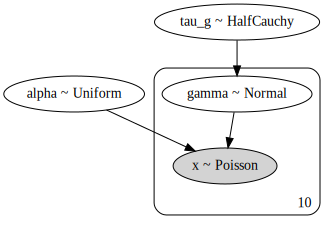

In [21]:
model_to_graphviz(model)

In [22]:
with model:
    trace = pm.sample(5000, n_init=10000,
                      tune=1000, random_seed=seed,
                      init='advi', chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 4,001.7: 100%|██████████| 10000/10000 [00:03<00:00, 2700.81it/s]  
Finished [100%]: Average Loss = 3,933.1
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, gamma, tau_g]
Sampling 2 chains: 100%|██████████| 12000/12000 [01:45<00:00, 113.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [24]:
eff_samples = az.effective_sample_size(trace).to_dataframe()

In [25]:
eff_samples = pd.DataFrame({
    'neff': eff_samples[["gamma"]].values[:,0] / 5000,
    'param': ['Gamma' + str(i) for i in range(eff_samples.shape[0])]
})

In [26]:
low_eff_samples = np.where(eff_samples['neff'].values < 0.1)
mid_eff_samples = np.where(
    np.logical_and(eff_samples['neff'].values >= 0.1 , eff_samples['neff'].values < 0.5))
high_eff_samples = np.where(eff_samples['neff'].values >= 0.5)

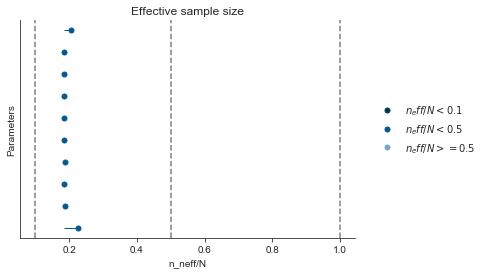

In [27]:
fig = plt.figure()
plt.axvline(x=0.1, color="grey", linestyle="--")
plt.axvline(x=0.5, color="grey", linestyle="--")
plt.axvline(x=1, color="grey", linestyle="--")

plt.hlines(y=eff_samples['param'].values[low_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[low_eff_samples],
           linewidth=1, color='#023858')
plt.hlines(y=eff_samples['param'].values[mid_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[mid_eff_samples],
           linewidth=1, color='#045a8d')
plt.hlines(y=eff_samples['param'].values[high_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[high_eff_samples],
           linewidth=1, color='#74a9cf')

plt.plot(eff_samples['neff'].values[low_eff_samples],
         eff_samples['param'].values[low_eff_samples],
         'o', color='#023858', label='$n_eff/N < 0.1$', markersize=5)
plt.plot(eff_samples['neff'].values[mid_eff_samples],
         eff_samples['param'].values[mid_eff_samples], 
         'o', color='#045a8d', label='$n_eff/N < 0.5$', markersize=5)
plt.plot(eff_samples['neff'].values[high_eff_samples], 
         eff_samples['param'].values[high_eff_samples], 
         'o', color='#74a9cf',  label='$n_eff/N >= 0.5$', markersize=5)

plt.title("Effective sample size")
plt.legend(bbox_to_anchor=(1.04, .5), loc="center left", frameon=False)
plt.xlabel("n_neff/N")
plt.ylabel("Parameters")
plt.yticks([])
plt.show()

In [28]:
rhat_samples = az.rhat(trace).to_dataframe()

In [29]:
rhat_samples = pd.DataFrame({
    'rhat': rhat_samples[["gamma"]].values[:,0],
    'param': ['Gamma' + str(i) for i in range(rhat_samples.shape[0])]
})

In [30]:
low_rhat_samples = np.where(rhat_samples['rhat'].values < 1.05)
mid_rhat_samples = np.where(
    np.logical_and(rhat_samples['rhat'].values >= 1.05 , rhat_samples['rhat'].values < 1.1))
high_rhat_samples = np.where(rhat_samples['rhat'].values >= 1.1)

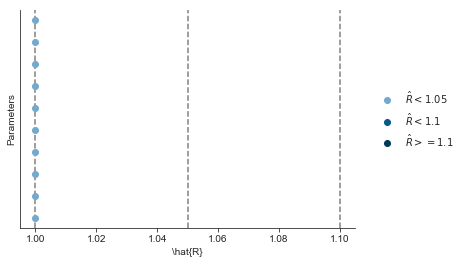

In [31]:
low_rhat_samples = np.where(rhat_samples['rhat'].values < 1.05)
mid_rhat_samples = np.where(
    np.logical_and(rhat_samples['rhat'].values >= 1.05 , rhat_samples['rhat'].values < 1.1))
high_rhat_samples = np.where(rhat_samples['rhat'].values >= 1.1)
fig = plt.figure()
plt.axvline(x=1.05, color="grey", linestyle="--")
plt.axvline(x=1.1, color="grey", linestyle="--")
plt.axvline(x=np.max(rhat_samples['rhat'].values), color="grey", linestyle="--")

plt.hlines(y=rhat_samples['param'].values[low_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[low_rhat_samples],
           linewidth=1, color='#74a9cf')
plt.hlines(y=rhat_samples['param'].values[mid_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[mid_rhat_samples],
           linewidth=1, color='#045a8d')
plt.hlines(y=rhat_samples['param'].values[high_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[high_rhat_samples],
           linewidth=1, color='#023858')

plt.plot(rhat_samples['rhat'].values[low_rhat_samples],
         rhat_samples['param'].values[low_rhat_samples],
         'o', color='#74a9cf', label=r'$\hat{R} < 1.05$')
plt.plot(rhat_samples['rhat'].values[mid_rhat_samples],
         rhat_samples['param'].values[mid_rhat_samples], 
         'o', color='#045a8d', label=r'$\hat{R} < 1.1$')
plt.plot(rhat_samples['rhat'].values[high_rhat_samples], 
         rhat_samples['param'].values[high_rhat_samples], 
         'o', color='#023858',  label='$\hat{R} >= 1.1$')

plt.legend(bbox_to_anchor=(1.04, .5), loc="center left", frameon=False)
plt.xlabel(r"\hat{R}")
plt.ylabel("Parameters")
plt.yticks([])
plt.show()

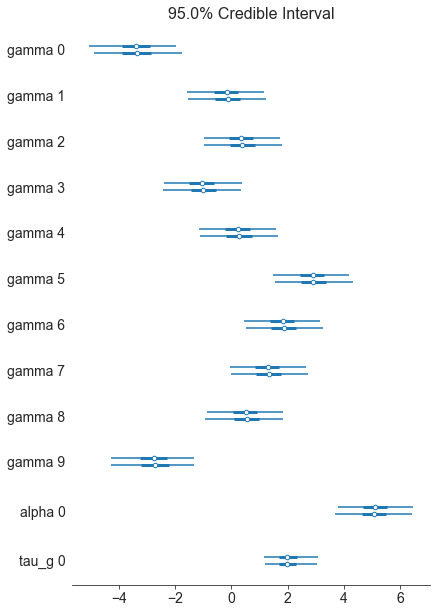

In [32]:
az.plot_forest(trace, credible_interval=0.95);

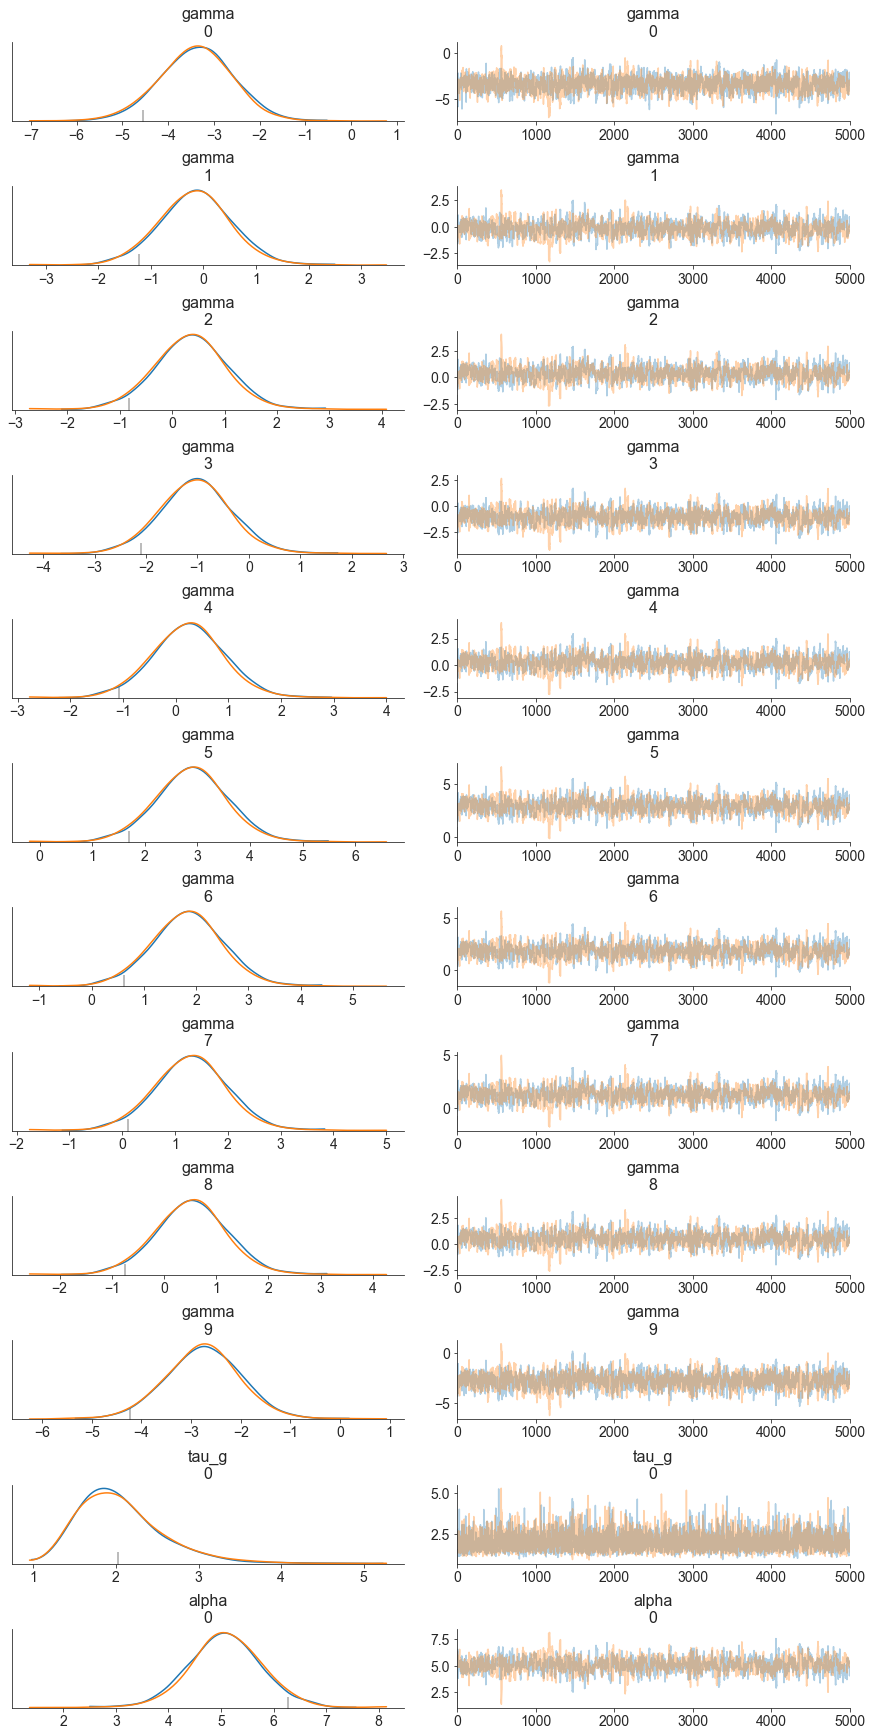

In [34]:
az.plot_trace(trace);

## Inference with a first multi-level w/o intercept

In [74]:
gamma_true = sp.stats.norm.rvs(0, tau_true, size=1)

In [75]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true

array([5.50288222, 2.63646376, 6.04719228])

In [76]:
beta_true = np.repeat(beta_true, 3)
beta_true

array([5.50288222, 5.50288222, 5.50288222, 2.63646376, 2.63646376,
       2.63646376, 6.04719228, 6.04719228, 6.04719228])

In [138]:
counts = sp.stats.poisson.rvs(
    np.exp(beta_true))

In [139]:
counts

array([240, 217, 277,  17,  13,  15, 432, 371, 422])

In [140]:
genes_idx = np.repeat(range(len(conditions)), len(genes))
alpha_idx = np.array([0] * count_table.shape[0])
beta_idx = np.repeat(range(len(genes) * len(conditions)), len(sgrnas) * len(replicates))
tau_b_idx = np.array([0] * len(genes) * len(conditions))

In [141]:
genes_idx = [0] * 9

In [142]:
beta_idx = np.repeat([0, 1, 2],  3)
beta_idx

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [175]:
with pm.Model() as model:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=1)
    
    tau_b = pm.HalfCauchy('tau_b', 1., shape=1)    
    beta = pm.Normal('beta', gamma[[0, 0, 0]], tau_b[[0, 0, 0]], shape=3)    
    #alpha = pm.Uniform('alpha', 0, 20, shape=1)
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(beta[beta_idx]),
        observed=counts)

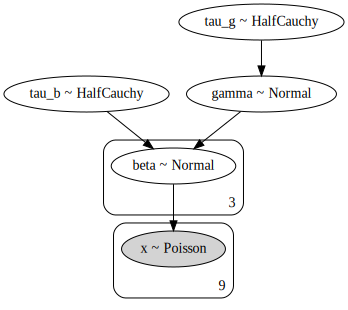

In [176]:
model_to_graphviz(model)

In [177]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, init="advi",
                      random_seed=seed, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 3,747.1: 100%|██████████| 10000/10000 [00:03<00:00, 2765.45it/s]
Finished [100%]: Average Loss = 3,740
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, tau_b, gamma, tau_g]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:51<00:00, 234.11draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [178]:
az.effective_sample_size(trace).to_dataframe()

,,,,gamma,beta,tau_g,tau_b
beta_dim_0,gamma_dim_0,tau_b_dim_0,tau_g_dim_0,,,,
0,0,0,0,604.0,10351.0,1746.0,1124.0
1,0,0,0,604.0,10772.0,1746.0,1124.0
2,0,0,0,604.0,9672.0,1746.0,1124.0


In [179]:
az.rhat(trace).to_dataframe()

,,,,gamma,beta,tau_g,tau_b
beta_dim_0,gamma_dim_0,tau_b_dim_0,tau_g_dim_0,,,,
0,0,0,0,1.01,1.0,1.0,1.0
1,0,0,0,1.01,1.0,1.0,1.0
2,0,0,0,1.01,1.0,1.0,1.0


In [180]:
eff_samples = az.effective_sample_size(trace).to_dataframe()
eff_samples = pd.DataFrame({
    'neff': eff_samples[["beta"]].values[:,0] / 5000,
    'param': ['Beta' + str(i) for i in range(eff_samples.shape[0])]
})

In [181]:
low_eff_samples = np.where(eff_samples['neff'].values < 0.1)
mid_eff_samples = np.where(
    np.logical_and(eff_samples['neff'].values >= 0.1 , eff_samples['neff'].values < 0.5))
high_eff_samples = np.where(eff_samples['neff'].values >= 0.5)

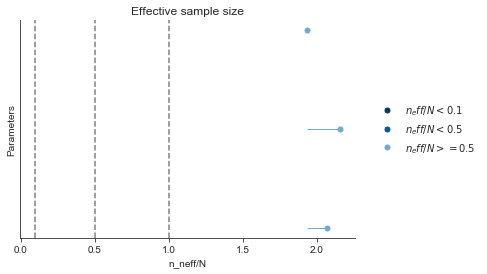

In [182]:
fig = plt.figure()
plt.axvline(x=0.1, color="grey", linestyle="--")
plt.axvline(x=0.5, color="grey", linestyle="--")
plt.axvline(x=1, color="grey", linestyle="--")

plt.hlines(y=eff_samples['param'].values[low_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[low_eff_samples],
           linewidth=1, color='#023858')
plt.hlines(y=eff_samples['param'].values[mid_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[mid_eff_samples],
           linewidth=1, color='#045a8d')
plt.hlines(y=eff_samples['param'].values[high_eff_samples],
           xmin=np.min(eff_samples['neff'].values),
           xmax=eff_samples['neff'].values[high_eff_samples],
           linewidth=1, color='#74a9cf')

plt.plot(eff_samples['neff'].values[low_eff_samples],
         eff_samples['param'].values[low_eff_samples],
         'o', color='#023858', label='$n_eff/N < 0.1$', markersize=5)
plt.plot(eff_samples['neff'].values[mid_eff_samples],
         eff_samples['param'].values[mid_eff_samples], 
         'o', color='#045a8d', label='$n_eff/N < 0.5$', markersize=5)
plt.plot(eff_samples['neff'].values[high_eff_samples], 
         eff_samples['param'].values[high_eff_samples], 
         'o', color='#74a9cf',  label='$n_eff/N >= 0.5$', markersize=5)

plt.title("Effective sample size")
plt.legend(bbox_to_anchor=(1.04, .5), loc="center left", frameon=False)
plt.xlabel("n_neff/N")
plt.ylabel("Parameters")
plt.yticks([])
plt.show()

In [183]:
rhat_samples = az.rhat(trace).to_dataframe()
rhat_samples = pd.DataFrame({
    'rhat': rhat_samples[["beta"]].values[:,0],
    'param': ['Beta' + str(i) for i in range(rhat_samples.shape[0])]
})

In [184]:
low_rhat_samples = np.where(rhat_samples['rhat'].values < 1.05)
mid_rhat_samples = np.where(
    np.logical_and(rhat_samples['rhat'].values >= 1.05 , rhat_samples['rhat'].values < 1.1))
high_rhat_samples = np.where(rhat_samples['rhat'].values >= 1.1)

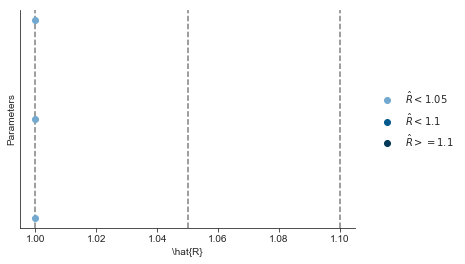

In [185]:
fig = plt.figure()
plt.axvline(x=1.05, color="grey", linestyle="--")
plt.axvline(x=1.1, color="grey", linestyle="--")
plt.axvline(x=np.max(rhat_samples['rhat'].values), color="grey", linestyle="--")

plt.hlines(y=rhat_samples['param'].values[low_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[low_rhat_samples],
           linewidth=1, color='#74a9cf')
plt.hlines(y=rhat_samples['param'].values[mid_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[mid_rhat_samples],
           linewidth=1, color='#045a8d')
plt.hlines(y=rhat_samples['param'].values[high_rhat_samples],
           xmin=np.min(rhat_samples['rhat'].values),
           xmax=rhat_samples['rhat'].values[high_rhat_samples],
           linewidth=1, color='#023858')

plt.plot(rhat_samples['rhat'].values[low_rhat_samples],
         rhat_samples['param'].values[low_rhat_samples],
         'o', color='#74a9cf', label=r'$\hat{R} < 1.05$')
plt.plot(rhat_samples['rhat'].values[mid_rhat_samples],
         rhat_samples['param'].values[mid_rhat_samples], 
         'o', color='#045a8d', label=r'$\hat{R} < 1.1$')
plt.plot(rhat_samples['rhat'].values[high_rhat_samples], 
         rhat_samples['param'].values[high_rhat_samples], 
         'o', color='#023858',  label='$\hat{R} >= 1.1$')

plt.legend(bbox_to_anchor=(1.04, .5), loc="center left", frameon=False)
plt.xlabel(r"\hat{R}")
plt.ylabel("Parameters")
plt.yticks([])
plt.show()

In [186]:
gamma_true

array([3.06364891])

In [187]:
beta_true

array([5.50288222, 5.50288222, 5.50288222, 2.63646376, 2.63646376,
       2.63646376, 6.04719228, 6.04719228, 6.04719228])

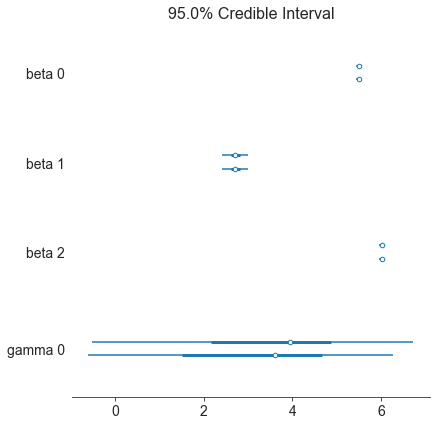

In [188]:
az.plot_forest(trace, credible_interval=0.95, var_names=["beta", "gamma"]);

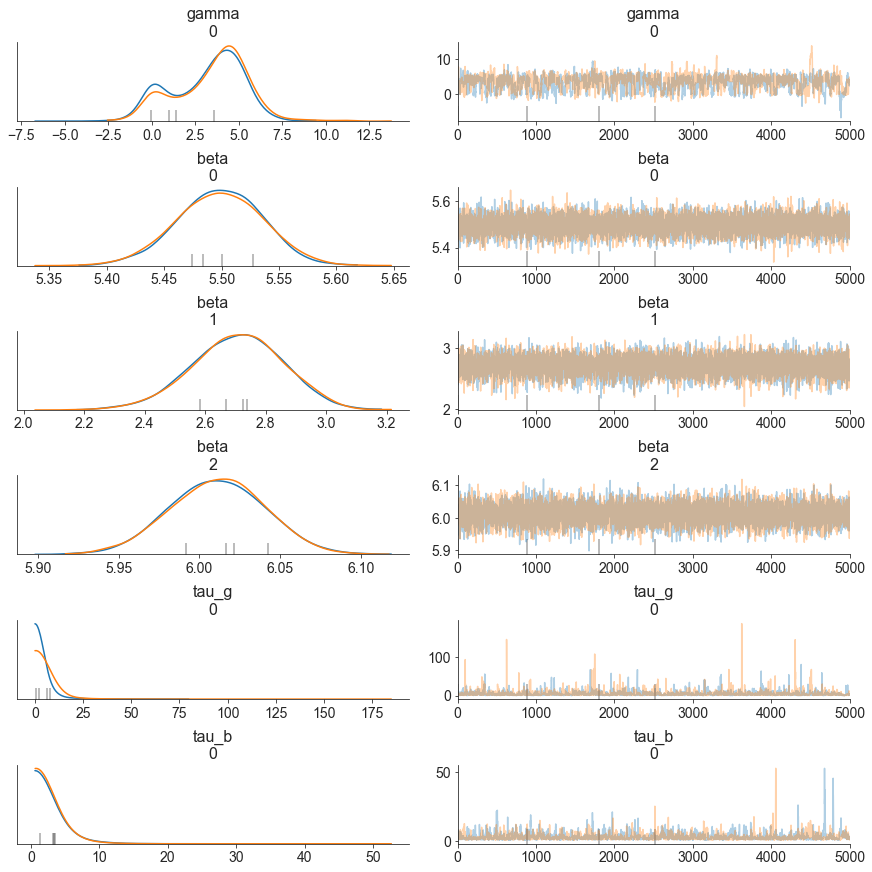

In [189]:
az.plot_trace(trace);

In [197]:
with pm.Model() as model_non_para:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=1)
    
    tau_b = pm.HalfCauchy('tau_b', 1., shape=1)
    beta_non_center = pm.Normal('beta_non', 0, 1, shape=3)    
    beta = pm.Deterministic('beta', np.sqrt(tau_b) * beta_non_center[beta_idx] + gamma[genes_idx])
        
    x = pm.Poisson(
        'x', 
        mu = np.exp(beta[beta_idx]),
        observed=counts)

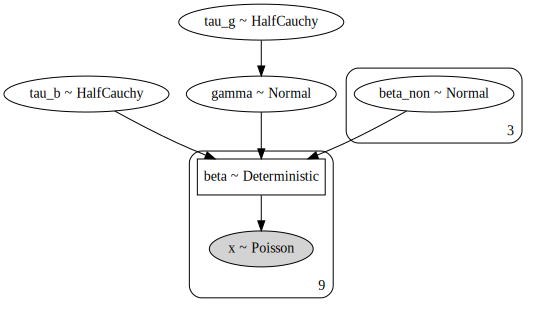

In [198]:
model_to_graphviz(model_non_para)

In [199]:
with model_non_para:
    trace_non_para = pm.sample(5000, n_init=10000, tune=1000, init="advi",
                               random_seed=seed, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 7,051.2:  59%|█████▊    | 5861/10000 [00:02<00:01, 2477.85it/s]
Convergence achieved at 6000
Interrupted at 5,999 [59%]: Average Loss = 6,636.3
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_non, tau_b, gamma, tau_g]
Sampling 2 chains: 100%|██████████| 12000/12000 [01:55<00:00, 103.52draws/s]
There were 287 divergences after tuning. Increase `target_accept` or reparameterize.
There were 226 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [200]:
az.rhat(trace_non_para).to_dataframe()

gamma  \
beta_dim_0 beta_non_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0          
0          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   
1          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   
2          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   
3          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   
4          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   
5          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   
6          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   
7          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   
8          0              0           0           0              1.0   
           1              0           0           0              1.0   
           2              0           0           0              1.0   

                                                               beta_non  \
beta_dim_0 beta_non_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0             
0          0              0           0           0                 1.0   
           1              0           0           0                 1.0   
           2              0           0           0                 1.0   
1          0              0           0           0                 1.0   
           1              0           0           0                 1.0   
           2              0           0           0                 1.0   
2          0              0           0           0                 1.0   
           1              0           0           0                 1.0   
           2              0           0           0                 1.0   
3          0              0           0           0                 1.0   
           1              0           0           0                 1.0   
           2              0           0           0                 1.0   
4          0              0           0           0                 1.0   
           1              0           0           0                 1.0   
           2              0           0           0                 1.0   
5          0              0           0           0                 1.0   
           1              0           0           0                 1.0   
           2              0           0           0                 1.0   
6          0              0           0           0                 1.0   
           1              0           0           0                 1.0   
           2              0           0           0                 1.0   
7          0              0           0           0                 1.0   
           1              0           0           0                 1.0   
           2              0           0           0                 1.0   
8          0            

In [201]:
az.effective_sample_size(trace_non_para).to_dataframe()

gamma  \
beta_dim_0 beta_non_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0          
0          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   
1          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   
2          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   
3          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   
4          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   
5          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   
6          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   
7          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   
8          0              0           0           0            945.0   
           1              0           0           0            945.0   
           2              0           0           0            945.0   

                                                               beta_non  \
beta_dim_0 beta_non_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0             
0          0              0           0           0              1651.0   
           1              0           0           0              5879.0   
           2              0           0           0              5754.0   
1          0              0           0           0              1651.0   
           1              0           0           0              5879.0   
           2              0           0           0              5754.0   
2          0              0           0           0              1651.0   
           1              0           0           0              5879.0   
           2              0           0           0              5754.0   
3          0              0           0           0              1651.0   
           1              0           0           0              5879.0   
           2              0           0           0              5754.0   
4          0              0           0           0              1651.0   
           1              0           0           0              5879.0   
           2              0           0           0              5754.0   
5          0              0           0           0              1651.0   
           1              0           0           0              5879.0   
           2              0           0           0              5754.0   
6          0              0           0           0              1651.0   
           1              0           0           0              5879.0   
           2              0           0           0              5754.0   
7          0              0           0           0              1651.0   
           1              0           0           0              5879.0   
           2              0           0           0              5754.0   
8          0            

In [204]:
beta_true

array([5.50288222, 5.50288222, 5.50288222, 2.63646376, 2.63646376,
       2.63646376, 6.04719228, 6.04719228, 6.04719228])

In [206]:
gamma_true

array([3.06364891])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fabb3dfceb8>,
      dtype=object)

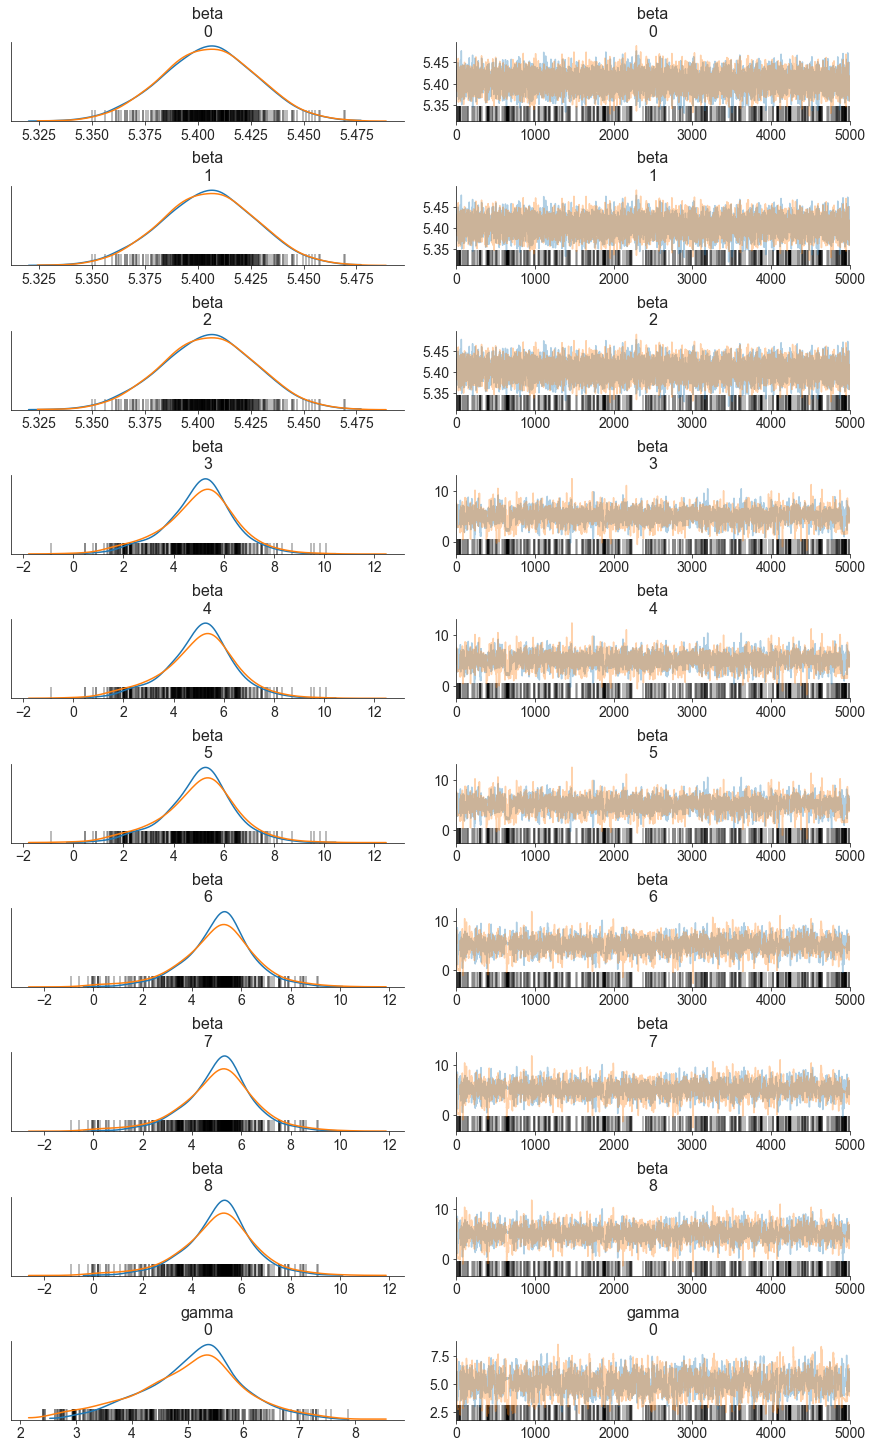

In [202]:
az.plot_trace(trace_non_para, var_names=["beta", "gamma"]);

## Multi-level intercept model

In [28]:
gamma_true = sp.stats.norm.rvs(0, tau_true)
gamma_true

1.0659373112027315

In [33]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true = np.repeat(beta_true, 3)

In [34]:
alpha_true = 2

In [54]:
counts = sp.stats.poisson.rvs(np.exp(beta_true) + alpha_true)
counts

array([29, 21, 42, 21, 16, 18, 14, 13, 13])

In [55]:
beta_idx = np.repeat([0, 1, 2], 3)
beta_idx

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [56]:
with pm.Model() as model:
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=1)
    
    tau_b = pm.HalfCauchy('tau_b', 1., shape=1)    
    beta = pm.Normal('beta', gamma[[0, 0, 0]], tau_b[[0, 0, 0]], shape=3)    
    alpha = pm.Uniform('alpha', 2, 3, shape=1)
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(beta[beta_idx]) + alpha,
        observed=counts)

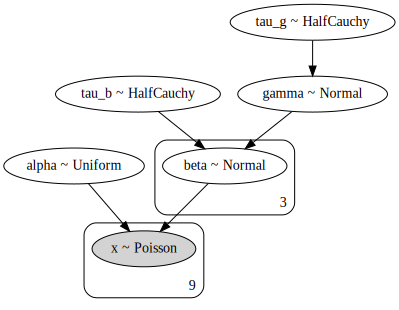

In [57]:
model_to_graphviz(model)

In [58]:
with model:
    trace= pm.sample(5000, n_init=10000, tune=1000, init="advi",
                     random_seed=seed, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 62.969: 100%|██████████| 10000/10000 [00:03<00:00, 2957.66it/s]
Finished [100%]: Average Loss = 62.775
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, beta, tau_b, gamma, tau_g]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:37<00:00, 632.91draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [60]:
az.rhat(trace).to_dataframe()

gamma  beta  \
alpha_dim_0 beta_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0                
0           0          0           0           0              1.0   1.0   
            1          0           0           0              1.0   1.0   
            2          0           0           0              1.0   1.0   

                                                            tau_g  tau_b  \
alpha_dim_0 beta_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0                 
0           0          0           0           0              1.0    1.0   
            1          0           0           0              1.0    1.0   
            2          0           0           0              1.0    1.0   

                                                            alpha  
alpha_dim_0 beta_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0         
0           0          0           0           0              1.0  
            1          0           0           0              1.0  
            2          0           0           0              1.0

In [61]:
az.effective_sample_size(trace).to_dataframe()

gamma     beta  \
alpha_dim_0 beta_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0                    
0           0          0           0           0            2036.0  19341.0   
            1          0           0           0            2036.0  23913.0   
            2          0           0           0            2036.0  18400.0   

                                                             tau_g   tau_b  \
alpha_dim_0 beta_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0                   
0           0          0           0           0            7758.0  2418.0   
            1          0           0           0            7758.0  2418.0   
            2          0           0           0            7758.0  2418.0   

                                                             alpha  
alpha_dim_0 beta_dim_0 gamma_dim_0 tau_b_dim_0 tau_g_dim_0          
0           0          0           0           0            7100.0  
            1          0           0           0            7100.0  
            2          0           0           0            7100.0

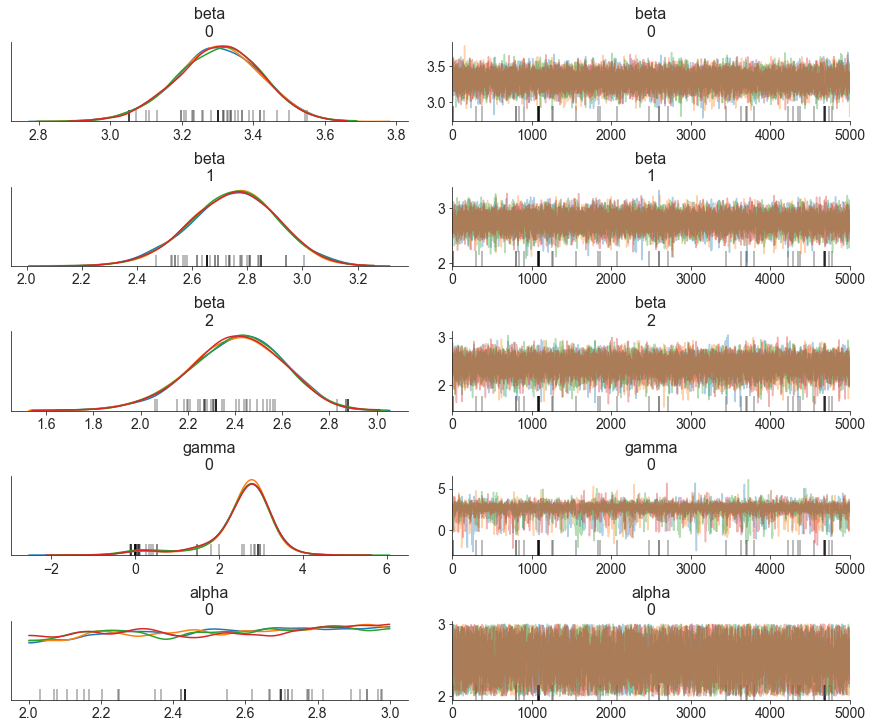

In [65]:
az.plot_trace(trace, var_names=["beta", "gamma", "alpha"]);

In [63]:
beta_true[[0, 3, 6]]

array([3.35581264, 2.70047996, 2.30412905])

In [64]:
gamma_true

1.0659373112027315

In [66]:
alpha_true

2

So, implementing an intercept yields non-identifiable models! That was expected.

## A model with sgRNAs

In [67]:
gamma_true = sp.stats.norm.rvs(0, tau_true)
gamma_true

2.51404639940893

In [68]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true

array([1.43743137, 2.30521915, 3.85482989])

In [76]:
l_true = sp.stats.lognorm.rvs(0.1, .1, size=9)
l_true

array([1.08887221, 1.06794358, 1.02967375, 1.04506062, 1.05965412,
       1.11880567, 1.18345758, 1.32683405, 1.10875248])

In [ ]:
counts = sp.stats.poisson.rvs(
    np.exp(beta_true))